In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def gaussian_kernel(kernel_size, sigma):
    """
    2D 가우시안 커널 생성
    - kernel_size: 커널 크기, 양의 홀수가 입력
    - sigma: 가우시안 분포의 표준편차, 실수를 받음
    """
    if kernel_size % 2 == 0:
        raise ValueError("kernel_size must be an odd number.")
    ax = np.linspace(-(kernel_size - 1) / 2, (kernel_size - 1) / 2, kernel_size)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    kernel /= np.sum(kernel)
    return kernel

def gaussian_kernel_1d(kernel_size, sigma):
    """
    1D 가우시안 커널 생성 함수.
    - kernel_size: 커널 길이 (홀수)
    - sigma: 가우시안 분포의 표준편차
    """
    if kernel_size % 2 == 0:
        raise ValueError("kernel_size must be an odd number.")
    ax = np.linspace(-(kernel_size - 1) / 2, (kernel_size - 1) / 2, kernel_size)
    kernel = np.exp(-0.5 * (ax / sigma)**2)
    kernel /= np.sum(kernel)
    return kernel

def pad_image_cv2(img, pad_h, pad_w, border_type=cv2.BORDER_CONSTANT, value=0):

    padded = cv2.copyMakeBorder(img, pad_h, pad_h, pad_w, pad_w, borderType=border_type, value=value)
    return padded

def convolve2d(image, kernel, border_type=cv2.BORDER_CONSTANT, value=0):
    """
    일반적인 2D 컨볼루션을 수행하는 함수 (그레이스케일 이미지 대상).
    """
    H, W = image.shape
    kH, kW = kernel.shape
    pad_h = kH // 2
    pad_w = kW // 2
    padded_image = pad_image_cv2(image, pad_h, pad_w, border_type, value)
    output = np.zeros((H, W), dtype=np.float64)
    # 컨볼루션 정의에 맞춰 커널 뒤집기
    kernel_flipped = np.flipud(np.fliplr(kernel))
    for x in range(H):
        for y in range(W):
            region = padded_image[x:x+kH, y:y+kW]
            output[x, y] = np.sum(region * kernel_flipped)
    return output

def convolve1d(image, kernel, axis, border_type=cv2.BORDER_CONSTANT, value=0):
    """
    1D 컨볼루션을 수행하는 함수 (그레이스케일 이미지 대상).
    
    Parameters:
      - image: 2D 그레이스케일 이미지
      - kernel: 1D 커널 (numpy array)
      - axis: 1이면 수평, 0이면 수직 컨볼루션
      - border_type, value: 패딩 옵션
    """
    kernel_size = kernel.shape[0]
    pad = kernel_size // 2
    kernel_flipped = np.flip(kernel)  # 가우시안 커널은 대칭이지만, 컨볼루션 정의를 위해 뒤집음
    H, W = image.shape
    output = np.zeros_like(image, dtype=np.float64)
    
    if axis == 1:
        # 수평 방향: 좌우에만 패딩 적용
        padded = pad_image_cv2(image, 0, pad, border_type, value)
        for i in range(H):
            for j in range(W):
                output[i, j] = np.sum(padded[i, j:j+kernel_size] * kernel_flipped)
    elif axis == 0:
        # 수직 방향: 상하에만 패딩 적용
        padded = pad_image_cv2(image, pad, 0, border_type, value)
        for i in range(H):
            for j in range(W):
                output[i, j] = np.sum(padded[i:i+kernel_size, j] * kernel_flipped)
    else:
        raise ValueError("Axis must be 0 (vertical) or 1 (horizontal)")
    
    return output

def apply_gaussian_blur(image, kernel_size, sigma, separable=True, border_type=cv2.BORDER_CONSTANT, value=0):
    """
    그레이스케일 이미지에 대해 가우시안 블러를 적용하는 함수.
    
    Parameters:
      - image: 2D 그레이스케일 이미지 (numpy array)
      - kernel_size: 가우시안 커널 크기 (홀수)
      - sigma: 가우시안 분포의 표준편차
      - separable: True이면 두 개의 1D 필터를 사용해 separable하게 처리,
                     False이면 2D 컨볼루션을 수행
      - border_type, value: 패딩 옵션
    """
    if separable:
        kernel_1d = gaussian_kernel_1d(kernel_size, sigma)
        intermediate = convolve1d(image, kernel_1d, axis=1, border_type=border_type, value=value)
        blurred = convolve1d(intermediate, kernel_1d, axis=0, border_type=border_type, value=value)
        return blurred
    else:
        kernel_2d = gaussian_kernel(kernel_size, sigma)
        return convolve2d(image, kernel_2d, border_type, value)

def filterGaussian(image, kernel_size, kernel_sigma, border_type, separable):
    """
    RGB 이미지에 대해 각 채널별로 가우시안 블러를 적용하는 함수.
    함수 시그니처는 다음과 같습니다:
      def filterGaussian(image, kernel_size, kernel_sigma, border_type, separable)
    
    Parameters:
      - image: RGB 이미지 (numpy array, shape: H x W x 3) 또는 그레이스케일 이미지
      - kernel_size: 가우시안 커널 크기 (홀수)
      - kernel_sigma: 가우시안 분포의 표준편차
      - border_type: 패딩 방식 (cv2.BORDER_CONSTANT, cv2.BORDER_REPLICATE, 
                     cv2.BORDER_REFLECT, cv2.BORDER_WRAP, cv2.BORDER_REFLECT_101)
      - separable: True이면 1D 필터를 두 번 사용하여 처리, False이면 2D 컨볼루션 사용
    """
    # RGB 이미지인 경우, 각 채널별로 처리 후 병합
    if len(image.shape) == 3 and image.shape[2] == 3:
        channels = cv2.split(image)
        blurred_channels = []
        for channel in channels:
            blurred = apply_gaussian_blur(channel, kernel_size, kernel_sigma, separable, border_type, value=0)
            blurred_channels.append(blurred.astype(channel.dtype))
        return cv2.merge(blurred_channels)
    else:
        # 그레이스케일 이미지인 경우 바로 적용
        return apply_gaussian_blur(image, kernel_size, kernel_sigma, separable, border_type, value=0)



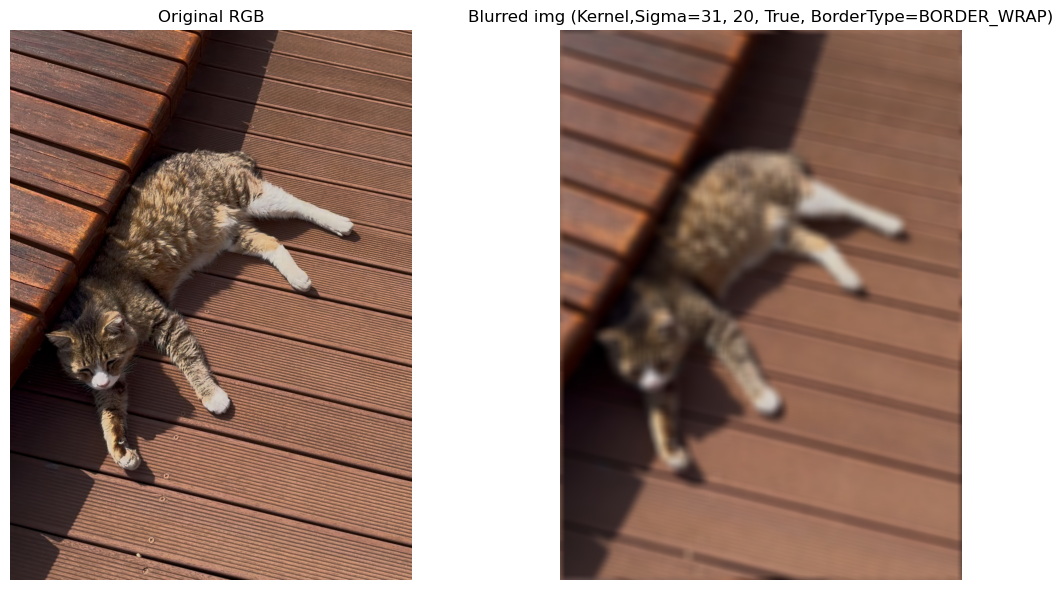

In [6]:
# ----------------------------------------------------------
# Results
# ----------------------------------------------------------
if __name__ == "__main__":
    
    
    # RGB 변환
    filename = "cat.jpg"
    image_bgr = cv2.imread(filename, cv2.IMREAD_COLOR)
    
    
    if image_bgr is None:
        print("이미지 를 불러올 수 없습니다.")
    else:
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        kernel_size = 31     # kernel size 
        kernel_sigma = 20    # sigma 
        border_type = cv2.BORDER_WRAP
        separable = True        
        
        
        # filterGaussian 함수를 이용하여 RGB 이미지에 가우시안 블러 적용
        blurred_rgb = filterGaussian(image_rgb, kernel_size, kernel_sigma, border_type, separable)
        
        # 동적으로 제목 생성 (오른쪽 결과 이미지)
        #title_text = f"Blurred img (Kernel={kernel_size}, Sigma={kernel_sigma}, Separable={separable}, BorderType={border_type})"
        border_names = {
        cv2.BORDER_CONSTANT: "BORDER_CONSTANT",
        cv2.BORDER_REPLICATE: "BORDER_REPLICATE",
        cv2.BORDER_REFLECT: "BORDER_REFLECT",
        cv2.BORDER_WRAP: "BORDER_WRAP",
        cv2.BORDER_REFLECT_101: "BORDER_REFLECT_101"
        }

        title_text = f"Blurred img (Kernel,Sigma={kernel_size}, {kernel_sigma}, {separable}, BorderType={border_names.get(border_type, border_type)})"

        
        
        # 결과 시각화
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.title("Original RGB")
        plt.imshow(image_rgb)
        plt.axis("off")
        
        plt.subplot(1, 2, 2)
        plt.title(title_text)
        plt.imshow(blurred_rgb)
        plt.axis("off")
        
        plt.tight_layout()
        
        # 파일 이름에 파라미터 값 반영하여 저장
        save_filename = f"color1_blurred_kernel{kernel_size}_sigma{kernel_sigma}_separable{separable}.jpg"
        plt.savefig(save_filename, dpi=300)
        
        plt.show()

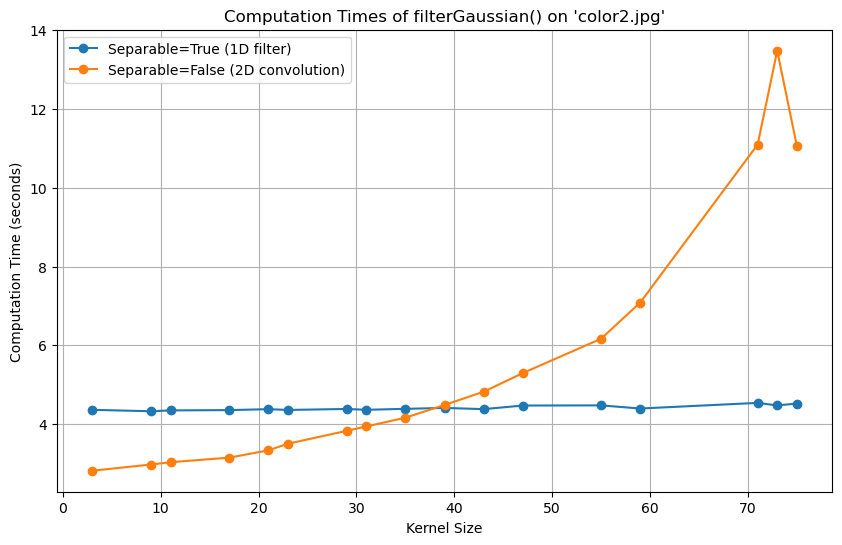

In [7]:
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt



image_bgr = cv2.imread("color2.jpg", cv2.IMREAD_COLOR)
if image_bgr is None:
    raise FileNotFoundError("이미지 'color2.jpg'를 찾을 수 없습니다.")
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)



# 다양한 kernel size (홀수 값들)
kernel_sizes = [3, 9, 11, 17, 21, 23, 29, 31, 35, 39, 43, 47, 55, 59, 71, 73, 75]

# 실행 시간을 저장할 리스트
times_separable_true = []
times_separable_false = []

# 각 kernel size와 separable 옵션에 대해 실행 시간 측정
for k in kernel_sizes:
    # separable = True인 경우
    start = time.time()
    _ = filterGaussian(image_rgb, k, 1.0, cv2.BORDER_REFLECT, True)
    elapsed_true = time.time() - start
    times_separable_true.append(elapsed_true)
    
    # separable = False인 경우
    start = time.time()
    _ = filterGaussian(image_rgb, k, 1.0, cv2.BORDER_REFLECT, False)
    elapsed_false = time.time() - start
    times_separable_false.append(elapsed_false)

# 결과를 그래프로 표시
plt.figure(figsize=(10, 6))
plt.plot(kernel_sizes, times_separable_true, marker='o', label='Separable=True (1D filter)')
plt.plot(kernel_sizes, times_separable_false, marker='o', label='Separable=False (2D convolution)')
plt.xlabel("Kernel Size")
plt.ylabel("Computation Time (seconds)")
plt.title("Computation Times of filterGaussian() on 'color2.jpg'")
plt.legend()
plt.grid(True)
plt.show()


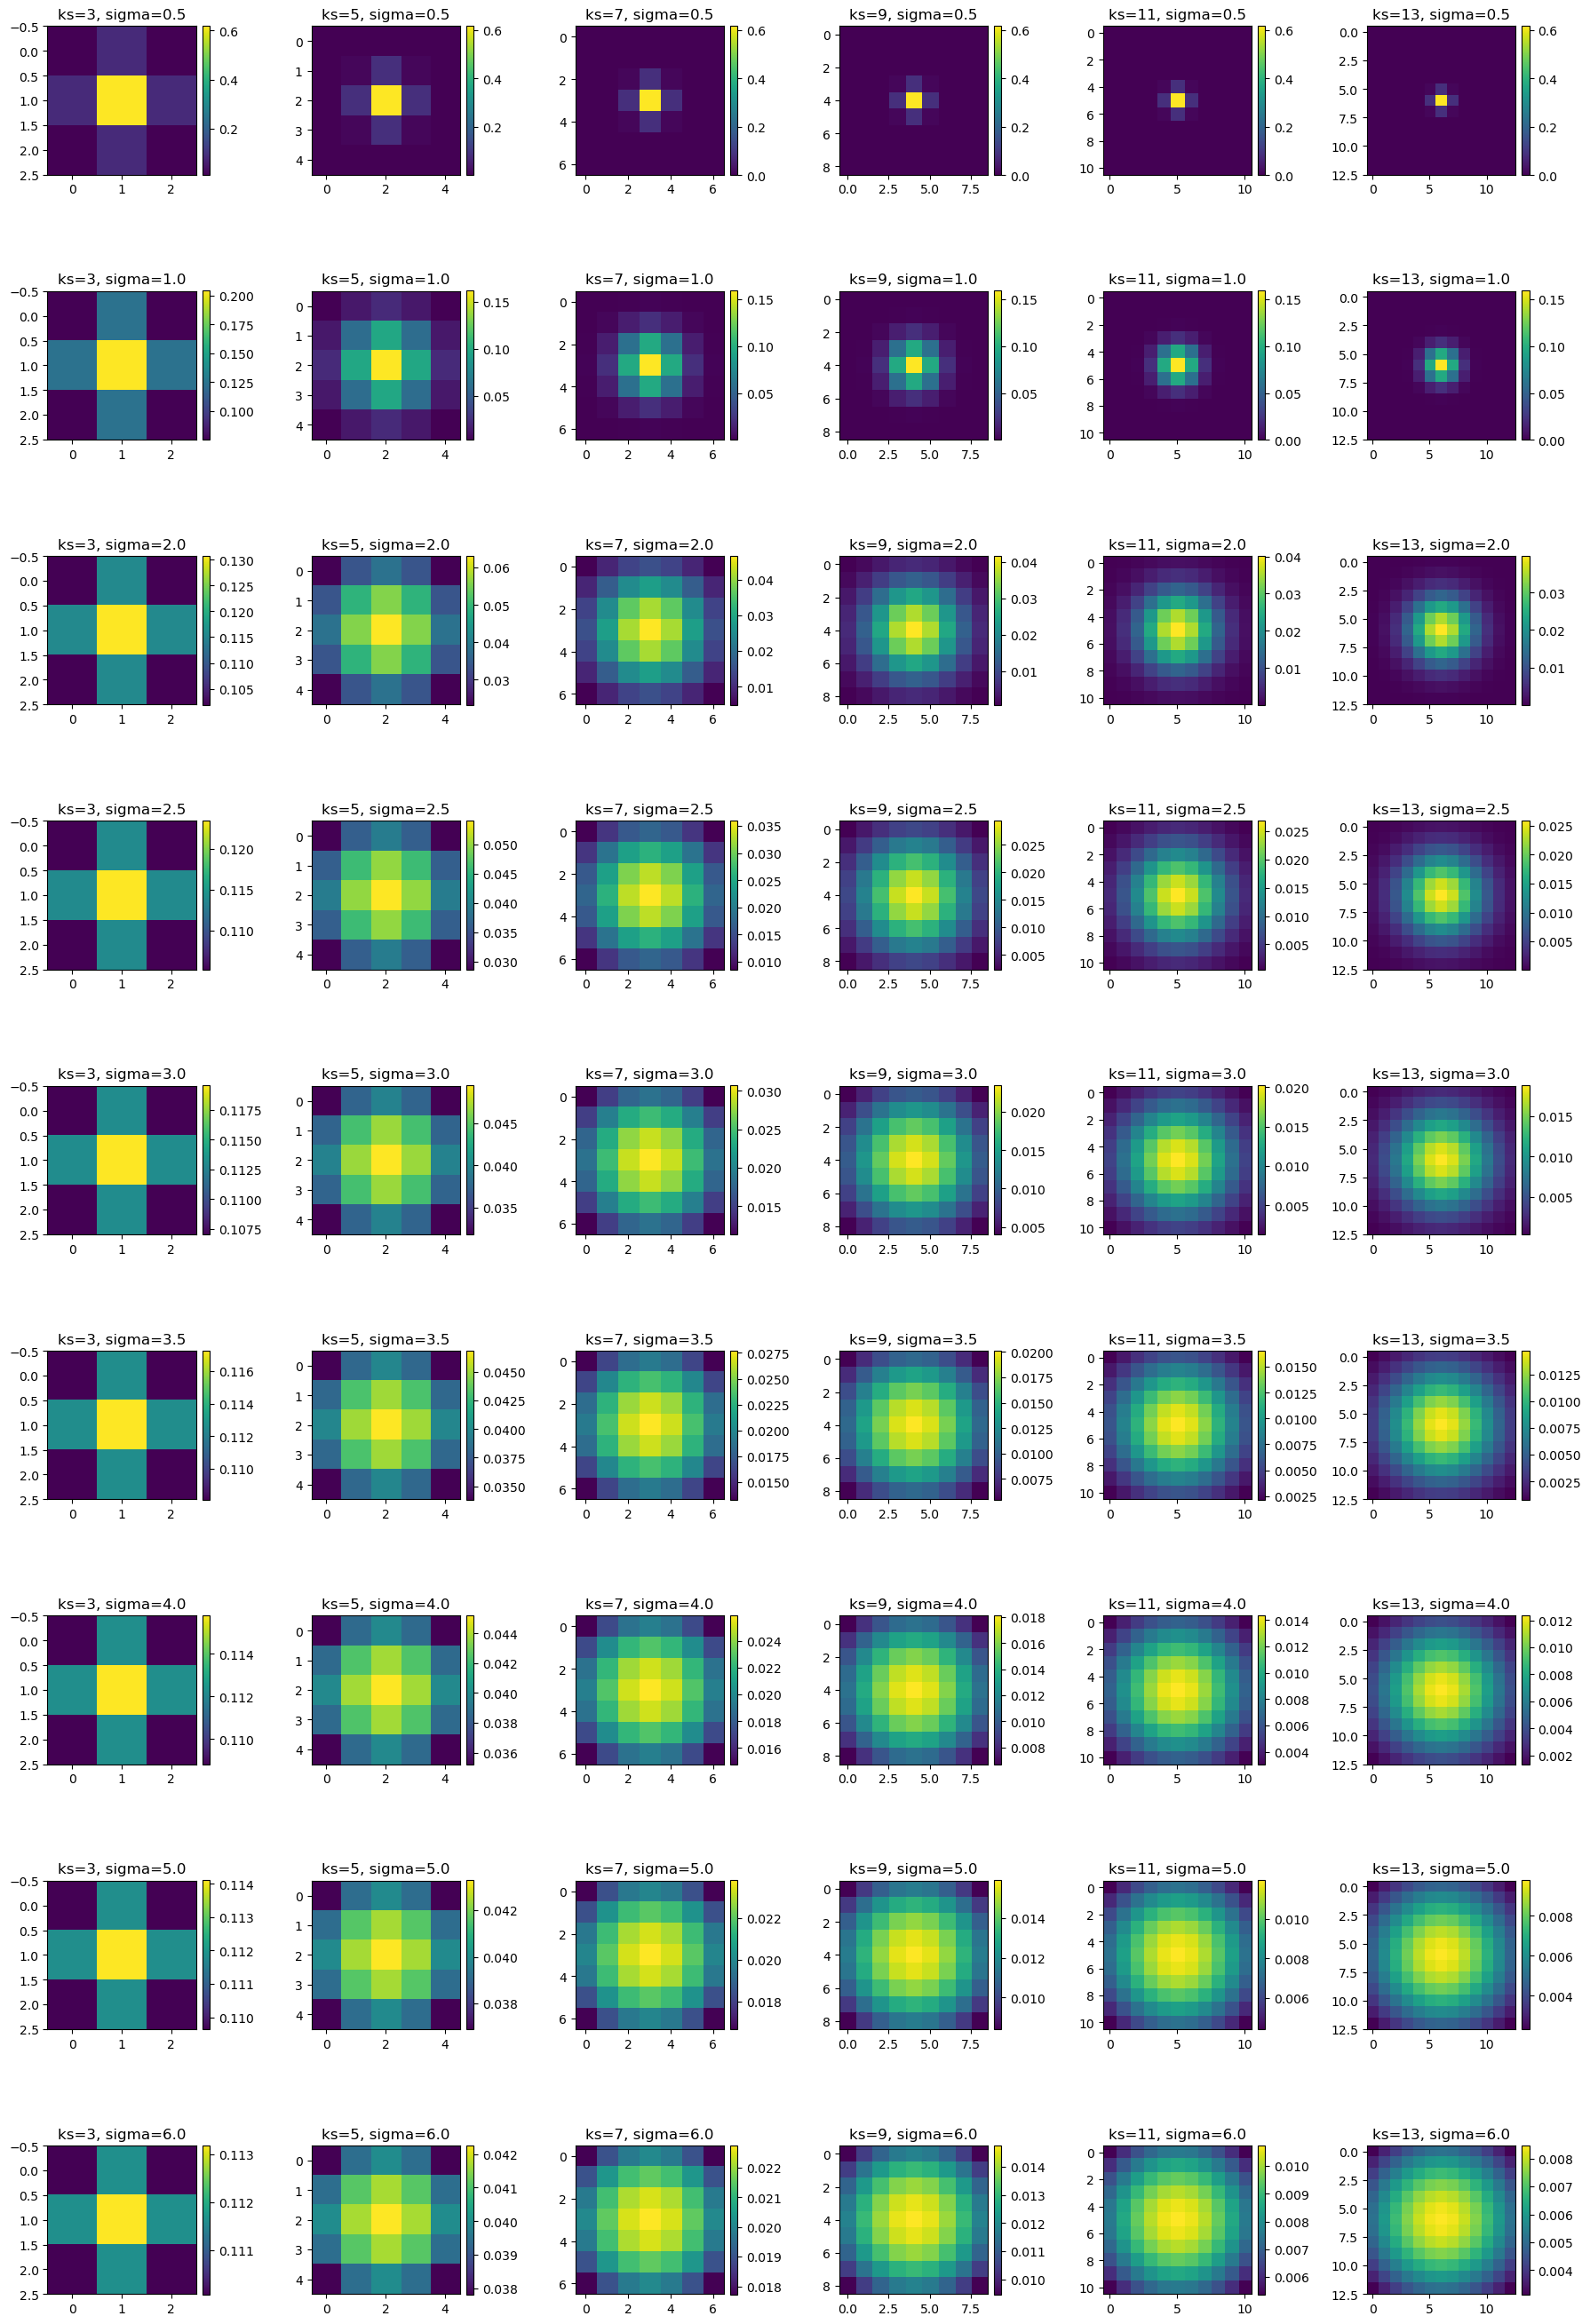

In [8]:
# 다양한 kernel_size와 sigma 값으로 커널 시각화
kernel_sizes = [3, 5, 7, 9, 11, 13]
sigmas = [0.5, 1.0, 2.0, 2.5, 3.0, 3.5, 4.0, 5.0, 6.0]

num_rows = len(sigmas)
num_cols = len(kernel_sizes)
plt.figure(figsize=(num_cols * 3, num_rows * 3))

for i, sigma in enumerate(sigmas):
    for j, ksize in enumerate(kernel_sizes):
         kernel = gaussian_kernel(ksize, sigma)
         plt.subplot(num_rows, num_cols, i * num_cols + j + 1)
         plt.imshow(kernel, cmap='viridis')
         plt.colorbar(fraction=0.046, pad=0.04)
         plt.title(f"ks={ksize}, sigma={sigma}")
         
plt.tight_layout()
plt.show()

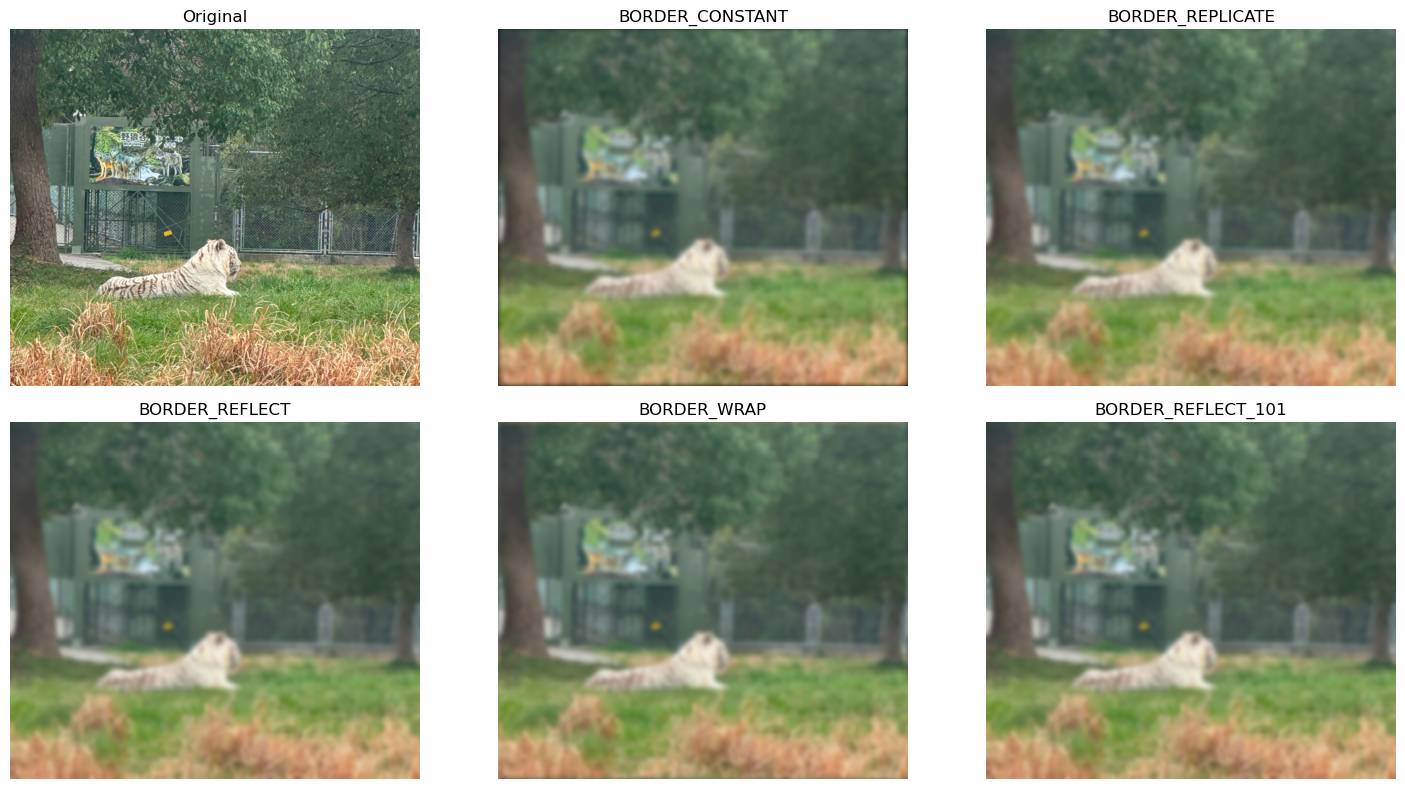

<Figure size 640x480 with 0 Axes>

In [10]:
# 컬러 이미지 로드 (cv2.imread는 기본적으로 BGR 순서이므로, RGB로 변환)
image_bgr = cv2.imread("tiger.jpg", cv2.IMREAD_COLOR)
if image_bgr is None:
    raise FileNotFoundError("이미지를 불러올 수 없습니다.")
    
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# 필터 파라미터 설정
kernel_size = 43 # 3*7 *2 + 1
kernel_sigma = 7
separable = True

# 다양한 경계 처리 옵션
border_types = [cv2.BORDER_CONSTANT, cv2.BORDER_REPLICATE, cv2.BORDER_REFLECT,
                cv2.BORDER_WRAP, cv2.BORDER_REFLECT_101]
border_names = ["BORDER_CONSTANT", "BORDER_REPLICATE", "BORDER_REFLECT",
                "BORDER_WRAP", "BORDER_REFLECT_101"]

results = []
for bt in border_types:
    result = filterGaussian(image_rgb, kernel_size, kernel_sigma, bt, separable)
    results.append(result)

# 결과 시각화: 원본 이미지와 각 경계 처리 결과 비교
num_results = len(results)
plt.figure(figsize=(15, 8))

# 원본 이미지 표시
plt.subplot(2, num_results//2+1, 1)
plt.imshow(image_rgb)
plt.title("Original")
plt.axis("off")

# 각 경계 처리 결과 표시
for i, (res, name) in enumerate(zip(results, border_names)):
    plt.subplot(2, num_results//2+1, i+2)
    plt.imshow(res)
    plt.title(name)
    plt.axis("off")

plt.tight_layout()
plt.show()

# 파일 이름에 파라미터 값 반영하여 저장
save_filename = f"BORDER_TIGER"
plt.savefig(save_filename, dpi=300)
